# Benchmarking S3 performance with pywren and AWS Lambda


In [1]:
%pylab inline

#STANDARD LIBARY IMPORTS
import numpy as np
import time
import pandas as pd
import pickle
import seaborn as sns
sns.set_style('whitegrid')

#PYTHON FILE
import s3_benchmark


Populating the interactive namespace from numpy and matplotlib


## Getting Started 

We are going to benchmark S3 by writing a large amount of data to a bucket, and then reading that data back. I created a bucket, `jonas-pywren-benchmark`, specifically for this purpose. 

In [2]:
# INFORMATION IS SENT TO S3_BENCHMARK.PY

# BUCKET_NAME: THIS SHOULD BE THE BUCKET THAT WAS CREATED WHEN YOU SET UP YOUR pywren
# MB-PER-FILE: MB OF EACH OBJECT IN S3
# NUMBER: NUMBER OF FILES

!python s3_benchmark.py write --bucket_name=fathe-pywren-815 --mb_per_file=10 \
--number=10 --outfile=write.pickle

We then run the read test

In [3]:
# INFORMATION IS SENT TO S3_BENCHMARK.PY

# KEY_FILE: FILENAME GENEREATED BY WRITE COMMAND (ABOVE)
# OUTFILE: READS PICKLE FILE

!python s3_benchmark.py read --key_file=write.pickle --outfile=read.pickle

Set up some code for preprocessing the results

In [4]:
# CREATE A NUMPY ARRAY OF EVENLY SPACED VALUES 
# BETWEEN 0 & 150. 
# SIZE: 150
runtime_bins = np.linspace(0, 150, 150)

# PARAM d: LIST
# RETURNS: DICTIONARY
def compute_times_rates(d):
    
    # CAST LIST AS NUMPY ARRAY
    x = np.array(d)
    
    # SELECTS ALL THE ELEMENTS (TUPLES) 
    # THEN, SELECTS THE FIRST ELEMENT FROM THE TUPLE
    # THEN, FIND THE SMALLEST VALUES
    tzero = np.min(x[:, 0])
    
    # SELECTS ALL THE ELEMENTS (TUPLES) 
    # THEN, SELECTS THE FIRST ELEMENT FROM THE TUPLE    
    # THEN, SUBTRACT THE BY ARRAY tzero
    start_time = x[:, 0] - tzero
   
    # SELECTS ALL THE ELEMENTS (TUPLES) 
    # THEN, SELECTS THE SECOND ELEMENT FROM THE TUPLE    
    # THEN, SUBTRACT THE BY ARRAY tzero    
    end_time = x[:, 1]  - tzero
    
    # SELECTS ALL THE ELEMENTS (TUPLES) 
    # THEN, SELECTS THE THIRD ELEMENT FROM THE TUPLE        
    rate = x[:, 2]

    #GET THE SIZE OF THE ARRAY
    N = len(start_time)

    # STORE AN ARRAY OF DIMENSION N WITH len(runtime_bins) ELEMENTS
    runtime_rate_hist = np.zeros((N, len(runtime_bins)))
    
    # STORE AN ARRAY OF DIMENSION N WITH len(runtime_bins) ELEMENTS
    runtime_jobs_hist = np.zeros((N, len(runtime_bins)))

    # ITERATE THROUGH EVERY ELEMENT IN START_TIME & END_TIME
    for i in range(N):
        
        #STORE ELEMENT IN INDEX I IN START_TIME LIST 
        s = start_time[i]
        e = end_time[i]
        
        #FIND INDICES WHERE ELMENETS SHOULD BE INSERTED TO MAINTAIN ORDER
        a, b = np.searchsorted(runtime_bins, [s, e])
        
        #CHECK IF INDEX B - INDEX A IS GREATER THAN ZERO
        if b-a > 0:
            runtime_rate_hist[i, a:b] = rate[i]
            runtime_jobs_hist[i, a:b] = 1
            
    #RETURN A DICTIONARY WITH THE FOLLOWING INFORMATION
    return {'start_time' : start_time, 
            'end_time' : end_time, 
            'rate' : rate, 
            'runtime_rate_hist' : runtime_rate_hist, 
            'runtime_jobs_hist' : runtime_jobs_hist}


# DESERIALIZE FILE, STORE A DICTIONARY
write_data = pickle.load(open("write.pickle", 'rb'))

# A LIST OF TUPLES ARE SENT TO THE FUNCTION
# STORES A DICTIONARY
write = compute_times_rates(write_data['results'])

# DESERIALIZE FILE, STORE A DICTIONARY
read_data = pickle.load(open("read.pickle", 'rb'))

# CREATES A LIST OF TUPLES 
# SELECTS ALL ELEMENTS, THEN
# SELECTS THE FIRST THREE ELEMENTS OF EACH TUPLE IN READ_DATA["RESULTS"]
read_time_results = [r[:3] for r in read_data['results']]

# A LIST OF TUPLES ARE SENT TO THE FUNCTION
# STORES A DICTIONARY
read  = compute_times_rates(read_time_results)


What is the distribution of read and write rates to S3 from our 2000 lambdas?

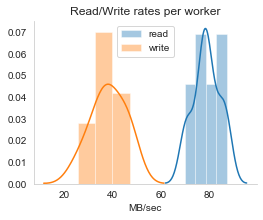

In [5]:
# STORE A SET OF COLORS 
current_palette = sns.color_palette()
# GET THE FIRST COLOR FROM THE PALETTE
read_color = current_palette[0]
# GET THE SECOND COLOR FROM THE PALETTE
write_color = current_palette[1]

# SET THE FIGURE SIZE FOR THE GRAPH
fig = pylab.figure(figsize=(4, 3))

# A HISTOGRAPH WITH A KERNAL DENSITY ESTIMATE 
sns.distplot(read['rate'], label='read', color=read_color)
sns.distplot(write['rate'], label='write', color=write_color)

# SHOWS A LEGEND (DEFAULT: TOP LEFT)
pylab.legend()
# CHANGE THE X-AXIS LABEL
pylab.xlabel("MB/sec")
# DOES NOT SHOW GRID
pylab.grid(False)
# CHANGE THE TILE LABEL
pylab.title("Read/Write rates per worker")

#DOES NOT SHOW THE TOP AND RIGHT BORDERS OF THE FIGURE
sns.despine()

#SAVE FIGURE AS A PNG
fig.savefig("s3_benchmark.rates.png")

We can investigate when jobs start and how long they run. Each horizontal line is a job, and then plotted on top is the aggregate number of jobs running at that moment. 

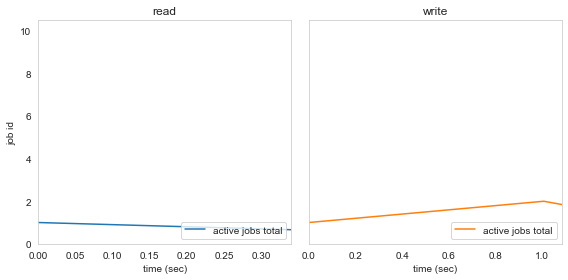

In [20]:
#STANDARD LIBARY IMPORTS
from matplotlib.collections import LineCollection

# SET THE FIGURE SIZE FOR THE GRAPH  
# KEEP REFERENCE IN VARIABLE
fig = pylab.figure(figsize=(8, 4))


for plot_i, (datum, l, c) in enumerate([(read, 'read', read_color), (write, 'write', write_color)]):
    
    #PLACE A SUBPLOT IN ROW 1, COL 2, INDEX 1 + PLOT_I
    # KEEP REFERENCE IN VARIABLE
    ax = fig.add_subplot(1, 2, 1 + plot_i)
    
    #GET THE SIZE OF THE NUMPY ARRAY
    N = len(datum['start_time'])
    
    
    # NOTE: HONESTLY, NOT SURE WHAT THIS IS FOR
    #line_segments = LineCollection([[[datum['start_time'][i], i], 
                                    # [datum['end_time'][i], i]] for i in range(N)],
                                  # linestyles='solid', color = "k", alpha=0.05, linewidth=0.4)
    #ax.add_collection(line_segments)

    
    # PLOT A LINE GRAPH
    ax.plot(runtime_bins, # X-VALUES FROM 0 TO 150
            datum['runtime_jobs_hist'].sum(axis=0), # ADDS ALL THE JOBS THAT HAPPENED ON THE FIRST ELEMENT IN EACH LIST
            c=c, # COLOR OF GRAPH
            label='active jobs total', # LABEL FOR GRAPH
            zorder=-1) # DECIDES WHAT IS DRAWN FIRST (patch,line,or text)
    
    #CHANGE THE TITLE OF FIGURE
    ax.set_title(l)

    #CHANGE THE X-AXIS RANGE FROM ZERO TO MAX END TIME
    ax.set_xlim(0, np.max(datum['end_time']))
    
    #CHANGE THE y-AXIS RANGE FROM ZERO TO MAX START TIME
    ax.set_ylim(0, len(datum['start_time'])*1.05)
    
    #CHANCE THE X-AXIS LABEL
    ax.set_xlabel("time (sec)")
    
    
    # ONLY THE FIRST GRAPH SHOULD HAVE THE Y-AXIS LABEL
    if plot_i == 0:
        # CHANGE THE Y-AXIS LABEL
        ax.set_ylabel("job id")
    else:
        # DISABLE Y-TICKS
        ax.set_yticks([])
        
    # DOES NOT SHOW GRID    
    ax.grid(False)
    # SHOWS A LEGEND (LOWER RIGHT)
    ax.legend(loc='lower right')
    

# AUTOMATICALLY ADJUST SUBPLOT PADDING
fig.tight_layout()

#SAVE FIGURE AS A PNG
fig.savefig("s3_benchmark.workers.png")

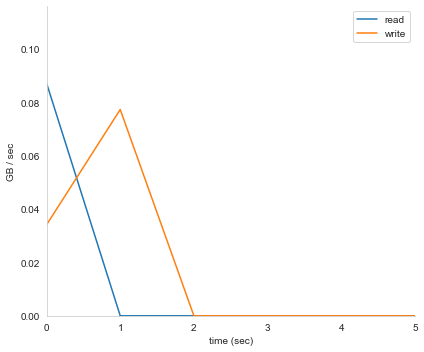

In [40]:
# SET THE FIGURE SIZE FOR THE GRAPH  
# KEEP REFERENCE IN VARIABLE
fig = pylab.figure(figsize=(6,5))

#PLACE A SUBPLOT IN ROW 1, COL 2, INDEX 1 
# KEEP REFERENCE IN VARIABLE
ax = fig.add_subplot(1, 1, 1)

for d, l, c in [(read, 'read', read_color), (write, 'write', write_color)]:
    
    #SAVE A 2D NYMPY ARRAY
    lst = d['runtime_rate_hist'].sum(axis=0)/1000
    
    # PLOT A LINE GRAPH
    ax.plot(lst, # TWO LIST ARE PRESENT (ONE FOR X AND OTHER FOR Y)
            label=l, # LABEL FOR LINE GRAPHs
            c=c) # COLOR OF GRAPH

    
# CHANGE THE X-AXIS RANGE FROM ZERO TO MAX END TIME
# ADJUST AS NEEDED
#ax.set_xlim(0, 5)

# CHANGE THE y-AXIS RANGE FROM ZERO TO MAX START TIME
ax.set_ylim(0, np.max(lst[1])*1.5)
    
# CHANGE X-AXIS LABEL    
ax.set_xlabel('time (sec)')

# CHANGE Y-AXIS LABEL
ax.set_ylabel("GB / sec")

# SHOWS A LEGEND (DEFAULT: TOP LEFT)
pylab.legend()

# DOES NOT SHOW GRID
ax.grid(False)

# DOES NOT SHOW THE TOP AND RIGHT BORDERS OF THE FIGURE
sns.despine()

# AUTOMATICALLY ADJUST SUBPLOT PADDING
fig.tight_layout()

# SAVE FIGURE AS A PNG
fig.savefig("s3_benchmark.tput.png")